In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Matchmaking changes to the Quick Match mode in Heroes of the Storm
Heroes of the Storm is a multiplayer online battle arena (MOBA) game by Blizzard, where two teams of five heroes from Blizzard games battle to destroy the enemy's core on one of several different maps. In the casual gamemode Quick Match (QM), players select a hero they want to play and enter a queue. The matchmaking system then tries to form teams from the pool of players in the queue.

Players use the QM mode for different things. For some it is the only gamemode they play, some use it to test out new heroes, some use it to warm up before jumping into a ranked mode. This makes it hard for the game team to balance the game mode as some players are looking for a testing ground that should correspond to a competitive environment while others are just in for some whacky games where anything goes.

In terms of matchmaking there are many things that a system may take into account. One of the goals shared by almost all systems is "fairness" of the game, so both teams have an equal chance at winning. However, in QM the players have no control over which other heroes will be on their team (unless they play in a party with friends) and the system has to take this into account so that games are enjoyable for the majority of players.

Some earlier iterations of the QM matchmaking algorithm have had some rules on the types of teams it will make, such as no more than one stealth hero in a team, no more than three warriors in a team, equal number of supports etc..<sup>[1]</sup> The purpose of these rules has been to have less "unfun" games where players have to play differently because of the team they were put into.

After years of complaints from some players the HotS team have decided to enforce strict rules for the types of team compositions that are allowed in Quick Match. As of November 28th 2018 the matchmaking algorithm will "prioritize creating teams with at least one Warrior, Support, and Ranged Assassin"<sup>[2]</sup>. Here I will analyze the effects of that change. How well is the system meeting this goal? How much were the queue times affected?

I used the fan driven open replay database HotsApi<sup>[3]</sup> to collect Quick Match data from two different weeks, one before the matchmaking change and one after.

***
[1] https://heroesofthestorm.gamepedia.com/Quick_Match

[2] https://heroesofthestorm.com/en-gb/blog/22791352/heroes-of-the-storm-balance-patch-notes-november-28-2018-2018-11-28/

[3] https://hotsapi.net/

In [2]:
before = pd.read_csv("../data/original/matches-2018-11-19--2018-11-26.csv", parse_dates = ["game_date"])
after = pd.read_csv("../data/original/matches-2018-12-03--2018-12-10.csv", parse_dates = ["game_date"])

## Are the team comps better after the change?

One integral part of the change is the upcoming rework to the roles system. The heroes are divided into six different roles: tank, bruiser, healer, support, melee assasin and ranged assasin. Out of those roles tanks, healers and ranged assasins are relevant to the matchmaking.

In [3]:
healers = ["Alexstrasza", "Ana", "Auriel", "Brightwing", "Deckard", "Kharazim", "Li Li", "Lt. Morales", 
            "Lúcio", "Malfurion", "Rehgar", "Stukov", "Tyrande", "Uther", "Whitemane"]
tanks = ["Anub'arak", 'Arthas', 'Blaze', 'Cho', 'Diablo', 'E.T.C.', 'Garrosh', 'Johanna',
         "Mal'Ganis", 'Muradin', 'Stitches', 'Tyrael',]
ranged_dps = ["Azmodan", "Cassia", "Chromie", "Falstad", "Fenix", "Cho'gall", "Genji", "Greymane",
              "Gul'dan", "Hanzo", "Jaina", "Junkrat", "Kael'thas", "Kel'Thuzad", "Li-Ming", "Lunara",
              "Mephisto", "Nazeebo", "Nova", "Orphea", "Probius", "Raynor", "Sgt. Hammer", "Sylvanas",
              "Tracer", "Tychus", "Valla", "Zagara", "Zul'jin"]

In [4]:
# Functions to count the number of tanks, healers and ranged assasins
def count_healers_tanks_ranged(df):
    team0_heroes = ["h" + str(x) for x in range(5)]
    team1_heroes = ["h" + str(x + 5) for x in range(5)]
    
    df["team0 healers"] = df[team0_heroes].apply(lambda x: len(set(x) & set(healers)), axis = 1)
    df["team0 tanks"] = df[team0_heroes].apply(lambda x: len(set(x) & set(tanks)), axis = 1)
    df["team0 ranged dps"] = df[team0_heroes].apply(lambda x: len(set(x) & set(ranged_dps)), axis = 1)
    
    df["team1 healers"] = df[team1_heroes].apply(lambda x: len(set(x) & set(healers)), axis = 1)
    df["team1 tanks"] = df[team1_heroes].apply(lambda x: len(set(x) & set(tanks)), axis = 1)
    df["team1 ranged dps"] = df[team1_heroes].apply(lambda x: len(set(x) & set(ranged_dps)), axis = 1)
    
def categorize_games(df):
    # Gives the game a category based on the number of healers and tanks in each team
    df["category"] = df.apply(lambda row: "H: " + str(sorted([row["team0 healers"], row["team1 healers"]])) + 
                                          " T: " + str(sorted([row["team0 tanks"], row["team1 tanks"]]))
                              , axis = 1)

In [5]:
count_healers_tanks_ranged(before)
categorize_games(before)

count_healers_tanks_ranged(after)
categorize_games(after)

### Games with no ranged assasins
Out of the three relevant roles the one with most heroes is ranged assasins. Ranged assasins are also often viewed as most fun to play, with many players opting for the high damage to have a higher impact on the game. Because of this I expect that fulfilling the ranged assasin role will not be a challenge for the system. Let us look at the number of games where at least one team is lacking a ranged assasin.

In [6]:
games_with_no_ranged_dps_before = before[(before["team0 ranged dps"] < 1) | (before["team1 ranged dps"] < 1)]
games_with_no_ranged_dps_after = after[(after["team0 ranged dps"] < 1) | (after["team1 ranged dps"] < 1)]
print("""Before the matchmaking change there were {}/{} ({:.1%}) games where at least one of the teams didn't have a ranged assasin"""
      .format(len(games_with_no_ranged_dps_before), 
              len(before),
              len(games_with_no_ranged_dps_before)/len(before)))
print("""After the matchmaking change there were {}/{} ({:.1%}) games where at least one of the teams didn't have a ranged assasin"""
      .format(len(games_with_no_ranged_dps_after), 
              len(after),
              len(games_with_no_ranged_dps_after)/len(after)))

Before the matchmaking change there were 878/32483 (2.7%) games where at least one of the teams didn't have a ranged assasin
After the matchmaking change there were 245/22262 (1.1%) games where at least one of the teams didn't have a ranged assasin


Since the number of non-ranged assasin games is so low in the following I will just focus on tanks and supports.

### Overall change in the number of team compositions

In [7]:
mask_before = (before[[col for col in before.columns if col.startswith("team")]] >= 1).all(axis =1)
print("Proportion of games with at least one healer, tank and ranged assasin:")
print("Before: {:.1%}".format(len(before[mask_before])/len(before)))

mask_after = (after[[col for col in after.columns if col.startswith("team")]] >= 1).all(axis =1) 
print("After: {:.1%}".format(len(after[mask_after])/len(after)))

Proportion of games with at least one healer, tank and ranged assasin:
Before: 30.8%
After: 89.2%


Before the change only 30.7% of games had the "traditional" team composition of one healer, tank and ranged assasin. After the change almost 90% of games fulfilled this rule. It seems that the change was implemented correctly and the system does achieve to make more games follow the traditional idea of a good team composition.

Let's look at the team comps in more detail. What were the other 70% of team compositions before the change and how have the numbers changed after?

In [8]:
def category_counts(df1, df2):
    df1_category_counts = df1.groupby("category").count()[["game_date"]]
    df2_category_counts = df2.groupby("category").count()[["game_date"]]
    counts = df1_category_counts.join(df2_category_counts, how = "outer", lsuffix = "l")
    counts = counts.rename(columns = {"game_datel": "counts before", "game_date": "counts after"}).fillna(0)
    counts["proportion before"] = counts["counts before"]/len(df1)
    counts["proportion after"] = counts["counts after"]/len(df2)
    return counts

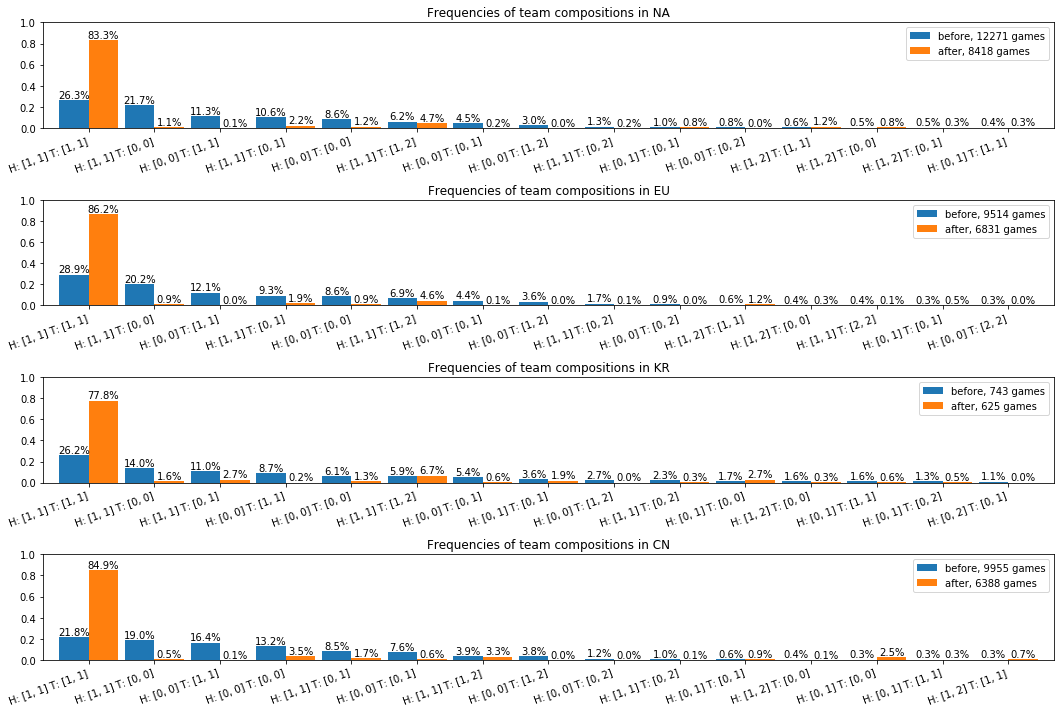

In [9]:
fig, ax = plt.subplots(4, figsize = (15,10))
regions = {1: "NA", 2: "EU", 3: "KR", 5: "CN"}
for i, region in enumerate([1,2,3,5]):
    before_region = before[before["region"] == region]
    after_region = after[after["region"] == region]
    counts = category_counts(before_region, after_region)
    counts[["proportion before","proportion after"]].sort_values("proportion before", ascending = False)[:15].plot.bar(width = 0.9, ax = ax[i])
    
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = 20, ha = "right")
    ax[i].set(ylim = [0,1], 
              title = "Frequencies of team compositions in {}".format(regions[region]), 
              xlabel = "")
    ax[i].legend(["before, {} games".format(len(before_region)), "after, {} games".format(len(after_region))])
    
    for p in ax[i].patches:
        # get_x pulls left or right; get_height pushes up or down
        ax[i].text(p.get_x() + 0.225, p.get_height()+ 0.02, \
                r'{:.1%}'.format(p.get_height()), horizontalalignment = "center")
fig.tight_layout()

The figure above shows the proportion of the 15 most frequent team compositions according to the tnumber of healers and tanks before the change and their proportions after the change. We can clearly see that the number of games with one healer and one tank in both teams has risen from around 20-30% to around 80%. At the same time almost all other compositions have almost vanished. An exception is the compostion withone team having one healer and tank and the other one having one healer and two tanks. This compostition falls into the rule of one healer, tank and ranged assasin in a team so it's numbers haven't changed.

## Queue times
With every change to the matchmaking system one has to consider whether the change will make queue times longer. This is especially true for *Quick* Match, where the players are looking to just play the game without the extra time required in draft modes. 

### Indirectly measuring queue times
As someone outside of the HotS development team I do not have access to the actual queue times. However, the replayfiles uploaded to HotsApi contain timestamps for each game. As far as I am aware these timestamps are saved when the replayfile is saved at the end of the match. Using these timestamps and the duration of the match I can calculate the time between matches or the inter-game time for individual players. However, just taking two consecutive games and calculating the time between them isn't the same as the queue time. What if the player just had a break before queueing up for the next game? Or had trouble loading into the next game?

Here I am forced to make an assumption. I assume that players have not changed their queuing behaviour with the matchmaking change<sup>1</sup>. I can then compare the distributions of the times between games before and after the change to see if there has been an overall increase.

***
<font size="2"><sup>1</sup>I know that to some degree this isn't true even for myself. After I have been in queue as an assasin for a time that feels too long I often change to a tank or a healer, i.e. I have changed my behaviour. I plan on making a more detailed statistical analysis where this assumption can be relaxed a bit.</font>

### Imbalanced datasets
Another problem that arizes from the dataset is imbalance. The users of HotsApi are allowed to upload their games whenever they wish and some players decide to upload for example once a month. This means that the number of recent matches in the database will be lower that the number of older matches. To combat the imbalance I am forced to sample the datasets so that they are more balanced.

With queue times I am mostly interested in consecutive games played by the same player. Optimally I would look at the players that uploaded their games to HotsApi because they are the most likely players to have all of their games in the database. However, there is no way of getting that information from HotsApi, so instead I will take a sample of 10 000 random players and only look at the inter-game times that are less than 20 minutes. I chose 20 minutes as the cut-off because on average games in HotS take about 20 minutes. This way I am not including times when the player was in a match that was not uploaded to the API.

In [10]:
def get_inter_event_times(df):
    cols = ["p" + str(x) for x in range(10)]
    df_filter = df[["game_date", "game_length"] + cols]
    num_games = pd.DataFrame(df_filter[cols].values.ravel(), columns = ["player"]).groupby("player").size().reset_index()
    players = num_games[num_games[0] > 1]["player"].sample(n = 10000)    
    
    inter_event_times = []
    for player in players:
        times = df_filter[(df_filter[cols] == player).any(axis = 1)].sort_values("game_date")[["game_date", "game_length"]]
        dates = times["game_date"].view('int64')//10**9
        game_start_times = (dates-times["game_length"]).iloc[1:].reset_index()[0]
        game_end_times = dates.iloc[:-1].reset_index()["game_date"]
        inter_event_times += list(game_start_times- game_end_times)
    return pd.DataFrame(inter_event_times, columns = ["event_times"])

In [11]:
event_times_before_EU = get_inter_event_times(before[before["region"] == 2])
event_times_after_EU = get_inter_event_times(after[after["region"] == 2])

In [12]:
event_times_before_NA = get_inter_event_times(before[before["region"] == 1])
event_times_after_NA = get_inter_event_times(after[after["region"] == 1])

In [13]:
event_times_EU = pd.DataFrame()
event_times_EU["before"] = event_times_before_EU["event_times"]
event_times_EU["after"] = event_times_after_EU["event_times"]
event_times_NA = pd.DataFrame()
event_times_NA["before"] = event_times_before_NA["event_times"]
event_times_NA["after"] = event_times_after_NA["event_times"]

In [14]:
def plot_waiting_times(df1, df2, cut_off, ax, title):
    bins = list(np.linspace(0, cut_off, 50))# + [10**5]
    df1.hist(normed = True, ax = ax, 
             alpha = 0.5, bins = bins, 
             label = "before, N = {}".format(len(event_times_before_EU)))
    df2.hist(normed = True, ax = ax, 
             alpha = 0.5, bins = bins, 
             label = "after, N = {}".format(len(event_times_after_EU)))
    ax.set(xlim = [0,cut_off], xlabel = r"$\Delta t (s)$", title = title)
    
    before_cut = df1[df1["event_times"].between(0,cut_off)]["event_times"]
    after_cut =  df2[df2["event_times"].between(0,cut_off)]["event_times"]
    
    ax.axvline(before_cut.mean(), linestyle = "--", c = "C0", label = "mean before, {:.1f} s".format(before_cut.mean()))
    ax.axvline(after_cut.mean(), linestyle = "--", c = "C1", label = "mean after, {:.1f} s".format(after_cut.mean()))
    ax.axvline(before_cut.median(), linestyle = ":", c = "C0", label = "median before, {:.1f} s".format(before_cut.median()))
    ax.axvline(after_cut.median(), linestyle = ":", c = "C1", label = "median after, {:.1f} s".format(after_cut.median()))
    leg = ax.legend()

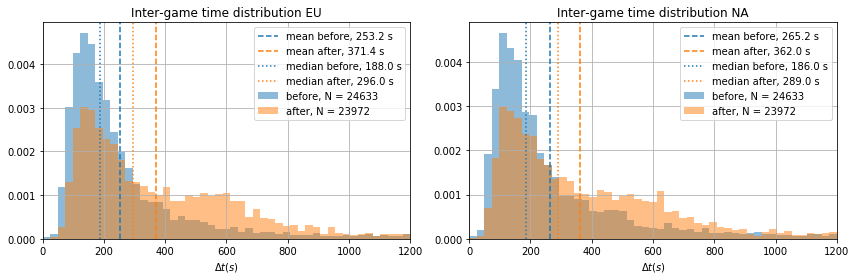

In [15]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
plot_waiting_times(event_times_before_EU, event_times_after_EU, 20*60, ax[0], "Inter-game time distribution EU")
plot_waiting_times(event_times_before_NA, event_times_after_NA, 20*60, ax[1], "Inter-game time distribution NA")
fig.tight_layout()

### Waiting time distributions
The figures above show the inter-game time distributions, i.e. the frequency of different times between two games for a player, before (blue) and after the change (orange). To keep the analysis closer to the actual queue times I have included only waiting times that are less than half an hour. There is a notisable change in the distributions. The frequency of low (0-250 s) times has gone down, while the longer (300-800 s) times has gone up. This leads to an increase of little over 100 s in the mean and median waiting times. 

In addition to the means and medians increasing we can clearly see a plateau around 300-600 s in the waiting times after the change. This is interesting because before the change there is no such plateau. Basically after you have waited for 300 seconds you are just as likely to wait for 400 s as 600 s.

**DISCLAIMER** This does not directly mean that queue times have increased by 100 s, because of the issues with indirectly measuring. All I can say for certain is that the time between games has increased. Some of this is due to increased queue times, but some is probably due to for example changing in queueing behaviour.

### How does role affect waiting times?

## What are the most popular times to play the game?

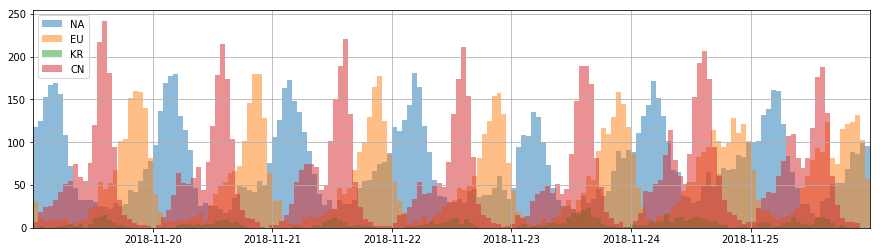

In [16]:
fig, ax = plt.subplots(figsize = (15,4))

for region, group in before.groupby("region")["game_date"]:
    group.hist(label = regions[region], bins = 7*24, alpha = 0.5, ax = ax)

#ax.set(xlim = [0,23])
ax.set(xlim = [before["game_date"].min(), before["game_date"].max()])    
ax.legend()

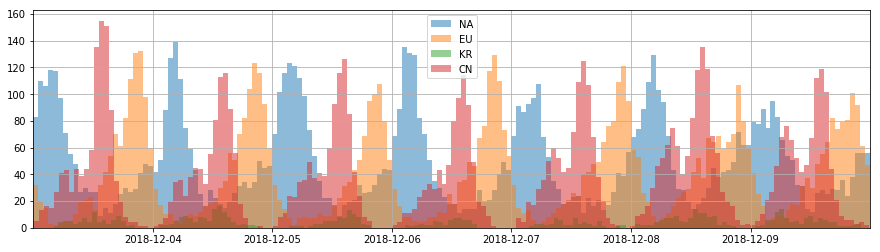

In [17]:
fig, ax = plt.subplots(figsize = (15,4))

for region, group in after.groupby("region")["game_date"]:
    group.hist(label = regions[region], bins = 7*24, alpha = 0.5, ax = ax)

ax.set(xlim = [after["game_date"].min(), after["game_date"].max()])
ax.legend()

### How does time of day affect queue times?

In [18]:
def get_inter_event_times_interval(df, interval, region):
    cols = ["p" + str(x) for x in range(10)]
    df_filter = df[(df.region == region)][["game_date", "game_length"] + cols]
    df_filter = df_filter.set_index("game_date").between_time(*interval).reset_index()
    num_games = pd.DataFrame(df_filter[cols].values.ravel(), columns = ["player"]).groupby("player").size().reset_index()
    players = num_games[num_games[0] > 1]["player"]
    
    inter_event_times = []
    for player in players:
        times = df_filter[(df_filter[cols] == player).any(axis = 1)].sort_values("game_date")[["game_date", "game_length"]]
        dates = times["game_date"].view('int64')//10**9
        game_start_times = (dates-times["game_length"]).iloc[1:].reset_index()[0]
        game_end_times = dates.iloc[:-1].reset_index()["game_date"]
        inter_event_times += list(game_start_times- game_end_times)
    return pd.DataFrame(inter_event_times, columns = ["event_times"])

"""
inter_event_times_night_EU1 = get_inter_event_times_interval(before, ("17:00","01:00"), 2)
inter_event_times_night_EU2 = get_inter_event_times_interval(after, ("17:00","01:00"), 2)

fig, ax = plt.subplots()
bins = list(np.linspace(0,30*60, 50)) + [10**5]
inter_event_times_night_EU1.hist(normed = True, ax = ax, alpha = 0.5, bins = bins, label = "before")
inter_event_times_night_EU2.hist(normed = True, ax = ax, alpha = 0.5, bins = bins, label = "after")
ax.set(xlim = [0,30*60], xlabel = r"$\Delta t (s)$", title = "Interevent time distribution")

cut_off_before = inter_event_times_night_EU1[inter_event_times_night_EU1["event_times"].between(0,15*60)]["event_times"]
cut_off_after = inter_event_times_night_EU2[inter_event_times_night_EU2["event_times"].between(0,15*60)]["event_times"]

ax.axvline(cut_off_before.mean(), linestyle = "--", c = "C0")
ax.axvline(cut_off_before.median(), linestyle = ":", c = "C0")
ax.axvline(cut_off_after.mean(), linestyle = "--", c = "C1")
ax.axvline(cut_off_after.median(), linestyle = ":", c = "C1")
ax.legend()

inter_event_times_night_EU1 = get_inter_event_times_interval(before, ("01:00","09:00"), 2)
inter_event_times_night_EU2 = get_inter_event_times_interval(after, ("01:00","09:00"), 2)

fig, ax = plt.subplots()
bins = list(np.linspace(0,30*60, 50)) + [10**5]
inter_event_times_night_EU1.hist(normed = True, ax = ax, alpha = 0.5, bins = bins, label = "before")
inter_event_times_night_EU2.hist(normed = True, ax = ax, alpha = 0.5, bins = bins, label = "after")
ax.set(xlim = [0,30*60], xlabel = r"$\Delta t (s)$", title = "Interevent time distribution")

cut_off_before = inter_event_times_night_EU1[inter_event_times_night_EU1["event_times"].between(0,15*60)]["event_times"]
cut_off_after = inter_event_times_night_EU2[inter_event_times_night_EU2["event_times"].between(0,15*60)]["event_times"]

ax.axvline(cut_off_before.mean(), linestyle = "--", c = "C0")
ax.axvline(cut_off_before.median(), linestyle = ":", c = "C0")
ax.axvline(cut_off_after.mean(), linestyle = "--", c = "C1")
ax.axvline(cut_off_after.median(), linestyle = ":", c = "C1")
ax.legend()

inter_event_times_night_EU1 = get_inter_event_times_interval(before, ("09:00","17:00"), 2)
inter_event_times_night_EU2 = get_inter_event_times_interval(after, ("09:00","17:00"), 2)

fig, ax = plt.subplots()
bins = list(np.linspace(0,30*60, 50)) + [10**5]
inter_event_times_night_EU1.hist(normed = True, ax = ax, alpha = 0.5, bins = bins, label = "before")
inter_event_times_night_EU2.hist(normed = True, ax = ax, alpha = 0.5, bins = bins, label = "after")
ax.set(xlim = [0,30*60], xlabel = r"$\Delta t (s)$", title = "Interevent time distribution")

cut_off_before = inter_event_times_night_EU1[inter_event_times_night_EU1["event_times"].between(0,15*60)]["event_times"]
cut_off_after = inter_event_times_night_EU2[inter_event_times_night_EU2["event_times"].between(0,15*60)]["event_times"]

ax.axvline(cut_off_before.mean(), linestyle = "--", c = "C0")
ax.axvline(cut_off_before.median(), linestyle = ":", c = "C0")
ax.axvline(cut_off_after.mean(), linestyle = "--", c = "C1")
ax.axvline(cut_off_after.median(), linestyle = ":", c = "C1")
ax.legend()
""";